# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500,
    },    
    
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var10_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var10_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0.493,0.428,0.435,0.438,0.435,0.353,0.512,0.271,0.391,0.612,0.715,0.686,0.414,0.467,0.515,4.000,9.000,9.000,0.000,0.000,1.000,6.000,1.000,4.000,7.000,5.000,3.000,3.000,3.000,7.000,0.000,0.906,0.042,0.445,0.135,0.727,0.037,0.769,0.697,0.169,0.657,0.929,0.469,0.777,0.145,0.541
1,0.623,0.569,0.477,0.519,0.390,0.386,0.639,0.502,0.445,0.474,0.480,0.665,0.669,0.675,0.097,0.000,0.000,9.000,0.000,1.000,8.000,0.000,9.000,9.000,6.000,9.000,0.000,0.000,6.000,2.000,0.989,0.999,0.700,0.946,0.000,0.250,0.582,0.769,0.121,0.019,0.259,0.101,0.564,0.784,0.833,0.304
2,0.648,0.542,0.606,0.431,0.534,0.421,0.748,0.427,0.479,0.304,0.601,0.521,0.493,0.676,0.537,2.000,5.000,7.000,6.000,2.000,1.000,9.000,5.000,8.000,1.000,6.000,5.000,5.000,7.000,0.000,0.154,0.368,0.696,0.396,0.389,0.843,0.242,0.793,0.900,0.159,0.170,0.015,0.647,0.980,1.000,0.000
3,0.476,0.536,0.542,0.687,0.545,0.351,0.602,0.461,0.564,0.527,0.543,0.410,0.572,0.344,0.519,3.000,4.000,7.000,9.000,6.000,9.000,0.000,9.000,7.000,9.000,0.000,1.000,3.000,8.000,1.000,0.656,0.953,0.075,0.838,0.288,0.684,0.571,0.918,0.000,1.000,0.277,0.086,0.637,0.218,0.522,0.883
4,0.497,0.497,0.630,0.634,0.582,0.608,0.493,0.417,0.465,0.580,0.630,0.227,0.449,0.556,0.323,4.000,1.000,7.000,8.000,7.000,5.000,2.000,1.000,7.000,2.000,7.000,7.000,1.000,9.000,9.000,0.014,0.146,0.777,0.069,0.920,0.518,0.357,0.000,0.403,0.912,0.071,0.957,0.059,0.667,0.000,0.964


In [11]:
X_data_list[0][0].head(10)

feat0   0.493
feat1   0.428
feat2   0.435
feat3   0.438
feat4   0.435
feat5   0.353
feat6   0.512
feat7   0.271
feat8   0.391
feat9   0.612
dtype: float64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.447,0.455,0.326,0.581,0.579,0.326,0.615,0.356,0.447,0.462
1,0.619,0.664,0.452,0.623,0.600,0.452,0.532,0.467,0.619,0.237
2,0.355,0.333,0.329,0.399,0.529,0.329,0.548,0.725,0.355,0.406
3,0.393,0.204,0.251,0.611,0.550,0.251,0.620,0.587,0.393,0.560
4,0.293,0.469,0.449,0.627,0.616,0.449,0.135,0.193,0.293,0.494
5,0.419,0.384,0.391,0.405,0.479,0.391,0.328,0.534,0.419,0.626
6,0.309,0.233,0.598,0.440,0.506,0.598,0.502,0.487,0.309,0.634
7,0.707,0.726,0.497,0.448,0.383,0.497,0.686,0.591,0.707,0.615
8,0.614,0.534,0.472,0.415,0.467,0.472,0.573,0.531,0.614,0.598
9,0.752,0.354,0.406,0.537,0.544,0.406,0.136,0.475,0.752,0.390


In [13]:
y_data_list[0][0].head(10)

feat0   0.493
feat1   0.428
feat2   0.435
feat3   0.438
feat4   0.435
feat5   0.353
feat6   0.512
feat7   0.271
feat8   0.391
feat9   0.612
dtype: float64

In [14]:
y_data_list[0][1].head(10)

,result
0,1
1,0
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,0


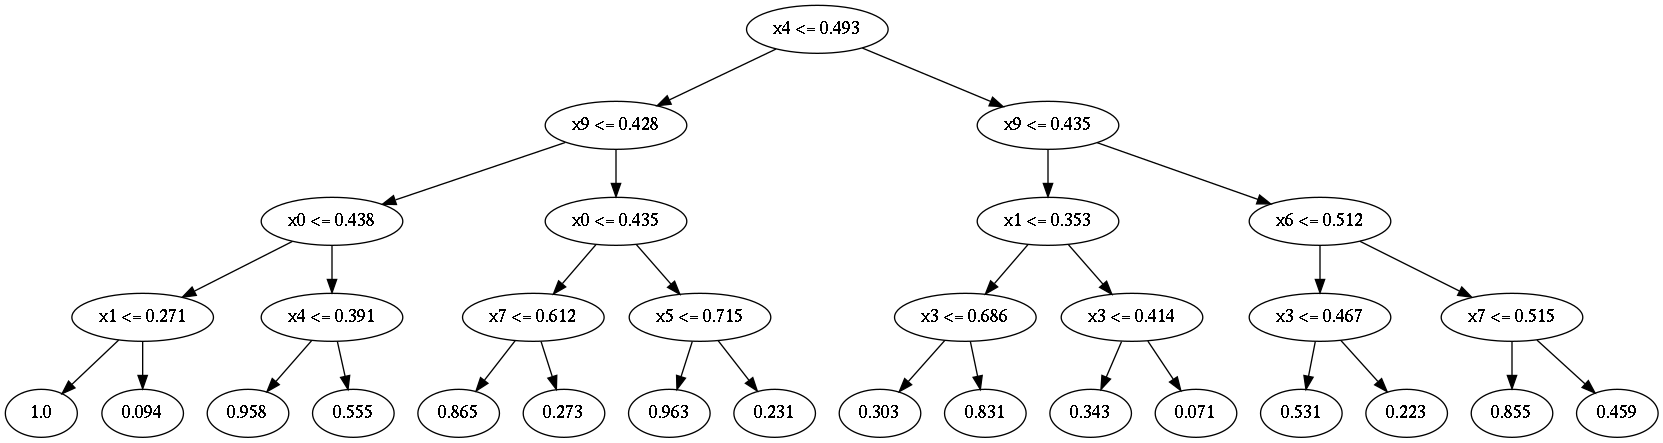

In [15]:
plot_tree_from_parameters(y_data_list[0][0].values, config)

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0   0.493
feat1   0.428
feat2   0.435
feat3   0.438
feat4   0.435
feat5   0.353
feat6   0.512
feat7   0.271
feat8   0.391
feat9   0.612
dtype: float64

In [19]:
y_data_list[0][0]

feat0     0.493
feat1     0.428
feat2     0.435
feat3     0.438
feat4     0.435
feat5     0.353
feat6     0.512
feat7     0.271
feat8     0.391
feat9     0.612
feat10    0.715
feat11    0.686
feat12    0.414
feat13    0.467
feat14    0.515
split0    4.000
split1    9.000
split2    9.000
split3    0.000
split4    0.000
split5    1.000
split6    6.000
split7    1.000
split8    4.000
split9    7.000
split10   5.000
split11   3.000
split12   3.000
split13   3.000
split14   7.000
lp0       0.000
lp1       0.906
lp2       0.042
lp3       0.445
lp4       0.135
lp5       0.727
lp6       0.037
lp7       0.769
lp8       0.697
lp9       0.169
lp10      0.657
lp11      0.929
lp12      0.469
lp13      0.777
lp14      0.145
lp15      0.541
dtype: float64

In [20]:
y_data_list[0][1].head(10)

,result
0,1
1,0
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

In [23]:
X_data_list[1][0]

feat0     0.623
feat1     0.569
feat2     0.477
feat3     0.519
feat4     0.390
feat5     0.386
feat6     0.639
feat7     0.502
feat8     0.445
feat9     0.474
feat10    0.480
feat11    0.665
feat12    0.669
feat13    0.675
feat14    0.097
split0    0.000
split1    0.000
split2    9.000
split3    0.000
split4    1.000
split5    8.000
split6    0.000
split7    9.000
split8    9.000
split9    6.000
split10   9.000
split11   0.000
split12   0.000
split13   6.000
split14   2.000
lp0       0.989
lp1       0.999
lp2       0.700
lp3       0.946
lp4       0.000
lp5       0.250
lp6       0.582
lp7       0.769
lp8       0.121
lp9       0.019
lp10      0.259
lp11      0.101
lp12      0.564
lp13      0.784
lp14      0.833
lp15      0.304
dtype: float64

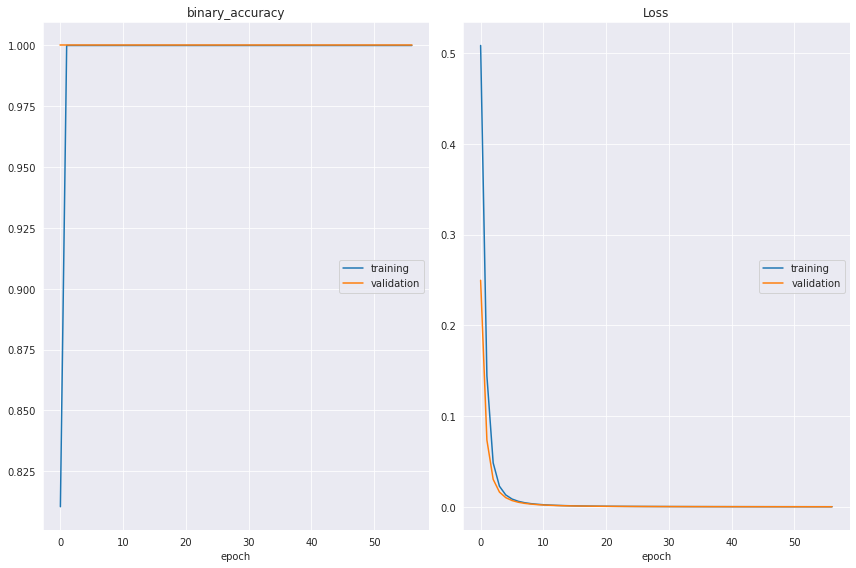

binary_accuracy
	training         	 (min:    0.810, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.509, cur:    0.000)
	validation       	 (min:    0.000, max:    0.250, cur:    0.000)


In [24]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [25]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:  3.0min
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:  7.8min
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed: 14.1min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed: 22.3min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed: 32.0min
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed: 43.0min
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed: 55.6min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed: 70.0min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed: 86.9min
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed: 105.2min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed: 125.3min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed: 146.8min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed: 170.7min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 194.4min
[Parallel(n_jobs=20)]: Done 8152 tasks  

In [26]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [27]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [28]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [30]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_421,loss_epoch_422,loss_epoch_423,loss_epoch_424,loss_epoch_425,loss_epoch_426,loss_epoch_427,loss_epoch_428,loss_epoch_429,loss_epoch_430,loss_epoch_431,loss_epoch_432,loss_epoch_433,loss_epoch_434,loss_epoch_435,loss_epoch_436,loss_epoch_437,loss_epoch_438,loss_epoch_439,loss_epoch_440,loss_epoch_441,loss_epoch_442,loss_epoch_443,loss_epoch_444,loss_epoch_445,loss_epoch_446,loss_epoch_447,loss_epoch_448,loss_epoch_449,loss_epoch_450,loss_epoch_451,loss_epoch_452,loss_epoch_453,loss_epoch_454,loss_epoch_455,loss_epoch_456,loss_epoch_457,loss_epoch_458,loss_epoch_459,loss_epoch_460,loss_epoch_461,loss_epoch_462,loss_epoch_463,loss_epoch_464,loss_epoch_465,loss_epoch_466,loss_epoch_467,loss_epoch_468,loss_epoch_469,loss_epoch_470,loss_epoch_471,loss_epoch_472,loss_epoch_473,loss_epoch_474,loss_epoch_475,loss_epoch_476,loss_epoch_477,loss_epoch_478,loss_epoch_479,loss_epoch_480,loss_epoch_481,loss_epoch_482,loss_epoch_483,loss_epoch_484,loss_epoch_485,loss_epoch_486,loss_epoch_487,loss_epoch_488,loss_epoch_489,loss_epoch_490,loss_epoch_491,loss_epoch_492,loss_epoch_493,loss_epoch_494,loss_epoch_495,loss_epoch_496,loss_epoch_497,loss_epoch_498,loss_epoch_499,loss_epoch_500,loss_epoch_501,loss_epoch_502,loss_epoch_503,loss_epoch_504,loss_epoch_505,loss_epoch_506,loss_epoch_507,loss_epoch_508,loss_epoch_509,loss_epoch_510,loss_epoch_511,loss_epoch_512,loss_epoch_513,loss_epoch_514,loss_epoch_515,loss_epoch_516,loss_epoch_517,loss_epoch_518,loss_epoch_519,loss_epoch_520
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9982.000,9952.000,9922.000,9888.000,9878.000,9865.000,9825.000,9743.000,9652.000,9553.000,9492.000,9444.000,9415.000,9358.000,9287.000,9211.000,9128.000,9068.000,8994.000,8943.000,8882.000,8818.000,8765.000,8717.000,8658.000,8603.000,8563.000,8512.000,8464.000,8419.000,8376.000,8325.000,8270.000,8225.000,8186.000,8148.000,8111.000,8073.000,8022.000,7971.000,7926.000,7881.000,7845.000,7809.000,...,41.000,41.000,40.000,37.000,36.000,35.000,34.000,32.000,29.000,28.000,25.000,25.000,25.000,25.000,24.000,24.000,24.000,22.000,22.000,22.000,22.000

In [31]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_421,val_loss_epoch_422,val_loss_epoch_423,val_loss_epoch_424,val_loss_epoch_425,val_loss_epoch_426,val_loss_epoch_427,val_loss_epoch_428,val_loss_epoch_429,val_loss_epoch_430,val_loss_epoch_431,val_loss_epoch_432,val_loss_epoch_433,val_loss_epoch_434,val_loss_epoch_435,val_loss_epoch_436,val_loss_epoch_437,val_loss_epoch_438,val_loss_epoch_439,val_loss_epoch_440,val_loss_epoch_441,val_loss_epoch_442,val_loss_epoch_443,val_loss_epoch_444,val_loss_epoch_445,val_loss_epoch_446,val_loss_epoch_447,val_loss_epoch_448,val_loss_epoch_449,val_loss_epoch_450,val_loss_epoch_451,val_loss_epoch_452,val_loss_epoch_453,val_loss_epoch_454,val_loss_epoch_455,val_loss_epoch_456,val_loss_epoch_457,val_loss_epoch_458,val_loss_epoch_459,val_loss_epoch_460,val_loss_epoch_461,val_loss_epoch_462,val_loss_epoch_463,val_loss_epoch_464,val_loss_epoch_465,val_loss_epoch_466,val_loss_epoch_467,val_loss_epoch_468,val_loss_epoch_469,val_loss_epoch_470,val_loss_epoch_471,val_loss_epoch_472,val_loss_epoch_473,val_loss_epoch_474,val_loss_epoch_475,val_loss_epoch_476,val_loss_epoch_477,val_loss_epoch_478,val_loss_epoch_479,val_loss_epoch_480,val_loss_epoch_481,val_loss_epoch_482,val_loss_epoch_483,val_loss_epoch_484,val_loss_epoch_485,val_loss_epoch_486,val_loss_epoch_487,val_loss_epoch_488,val_loss_epoch_489,val_loss_epoch_490,val_loss_epoch_491,val_loss_epoch_492,val_loss_epoch_493,val_loss_epoch_494,val_loss_epoch_495,val_loss_epoch_496,val_loss_epoch_497,val_loss_epoch_498,val_loss_epoch_499,val_loss_epoch_500,val_loss_epoch_501,val_loss_epoch_502,val_loss_epoch_503,val_loss_epoch_504,val_loss_epoch_505,val_loss_epoch_506,val_loss_epoch_507,val_loss_epoch_508,val_loss_epoch_509,val_loss_epoch_510,val_loss_epoch_511,val_loss_epoch_512,val_loss_epoch_513,val_loss_epoch_514,val_loss_epoch_515,val_loss_epoch_516,val_loss_epoch_517,val_loss_epoch_518,val_loss_epoch_519,val_loss_epoch_520
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,

In [32]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_421,binary_accuracy_epoch_422,binary_accuracy_epoch_423,binary_accuracy_epoch_424,binary_accuracy_epoch_425,binary_accuracy_epoch_426,binary_accuracy_epoch_427,binary_accuracy_epoch_428,binary_accuracy_epoch_429,binary_accuracy_epoch_430,binary_accuracy_epoch_431,binary_accuracy_epoch_432,binary_accuracy_epoch_433,binary_accuracy_epoch_434,binary_accuracy_epoch_435,binary_accuracy_epoch_436,binary_accuracy_epoch_437,binary_accuracy_epoch_438,binary_accuracy_epoch_439,binary_accuracy_epoch_440,binary_accuracy_epoch_441,binary_accuracy_epoch_442,binary_accuracy_epoch_443,binary_accuracy_epoch_444,binary_accuracy_epoch_445,binary_accuracy_epoch_446,binary_accuracy_epoch_447,binary_accuracy_epoch_448,binary_accuracy_epoch_449,binary_accuracy_epoch_450,binary_accuracy_epoch_451,binary_accuracy_epoch_452,binary_accuracy_epoch_453,binary_accuracy_epoch_454,binary_accuracy_epoch_455,binary_accuracy_epoch_456,binary_accuracy_epoch_457,binary_accuracy_epoch_458,binary_accuracy_epoch_459,binary_accuracy_epoch_460,binary_accuracy_epoch_461,binary_accuracy_epoch_462,binary_accuracy_epoch_463,binary_accuracy_epoch_464,binary_accuracy_epoch_465,binary_accuracy_epoch_466,binary_accuracy_epoch_467,binary_accuracy_epoch_468,binary_accuracy_epoch_469,binary_accuracy_epoch_470,binary_accuracy_epoch_471,binary_accuracy_epoch_472,binary_accuracy_epoch_473,binary_accuracy_epoch_474,binary_accuracy_epoch_475,binary_accuracy_epoch_476,binary_accuracy_epoch_477,binary_accuracy_epoch_478,binary_accuracy

In [33]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_421,val_binary_accuracy_epoch_422,val_binary_accuracy_epoch_423,val_binary_accuracy_epoch_424,val_binary_accuracy_epoch_425,val_binary_accuracy_epoch_426,val_binary_accuracy_epoch_427,val_binary_accuracy_epoch_428,val_binary_accuracy_epoch_429,val_binary_accuracy_epoch_430,val_binary_accuracy_epoch_431,val_binary_accuracy_epoch_432,val_binary_accuracy_epoch_433,val_binary_accuracy_epoch_434,val_binary_accuracy_epoch_435,val_binary_accuracy_epoch_436,val_binary_accuracy_epoch_437,val_binary_accuracy_epoch_438,val_binary_accuracy_epoch_439,val_binary_accuracy_epoch_440,val_binary_accuracy_epoch_441,val_binary_accuracy_epoch_442,val_binary_accuracy_epoch_443,val_binary_accuracy_epoch_444,val_binary_accuracy_epoch_445,val_binary_accuracy_epoch_446,val_binary_accuracy_epoch_447,val_binary_accuracy_epoch_448,val_binary_accuracy_epoch_449,val_binary_accuracy_epoch_450,val_binary_accuracy_epoch_451,val_binary_accuracy_epoch_452,val_binary_accuracy_epoch_453,val_binary_accuracy_epoch_454,val_binary_accuracy_epoch_455,val_binary_accuracy_epoch_456,val_binary_accuracy_epoch_457,val_binary_accura

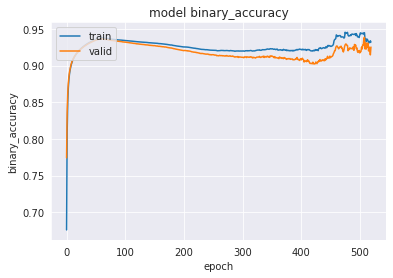

In [34]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


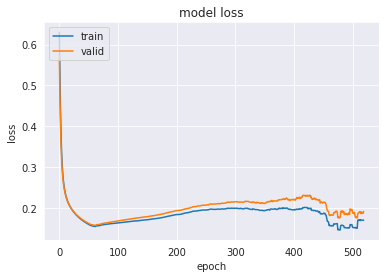

In [35]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
